# ACSE-8
## Coursework 2 - Training a classifier on CIFAR10

You task in this coursework is to implement, train and validate a classifier on the CIFAR10 dataset.  
You are free to use the code provided previously in the classroom exercises - but that code will need to be adapted to work on CIFAR10. 

Complete the following tasks:

1. Use ```torchvision.datasets.CIFAR10``` to load the CIFAR10 dataset. (1 point)
2. Plot 25 images of the training set together with their corresponding label names. (1 point)
3. Create a (90-10) training and validation split using ```sklearn.model_selection.StratifiedShuffleSplit```  (1 point)
4. Instantiate Datasets and Dataloader with correctly normalized CIFAR10, training, validation and test data. (1 point)
5. Modify LeNet5 from the morning excercise to be able to work with CIFAR10. (3 points)
6. Perform a line-search over the L2-Regularization parameter, use the ```weight_decay=value``` keyword argument in the ```torch.optim``` modules (5 points).
  - Other Hyperparameters:
    - Random Number Seed 42
    - Learning Rate = 1e-2
    - Momentum = 0.5
    - Batch Size = 64
    - Test Batch Size = 1000
    - Number of Epochs = 30
    - Optimizer = SGD
 - Values of weight_decay to use in line search: ```[0.0, 1e-3, 1e-4, 1e-5]```
7. Choose the best weight-decay value given the other hyperparameters and train on the full CIFAR10 training set (2 points).
8. Test your final model on the test set and store the model parameters in a ```.pth``` file (2 points).
9. Answer the following questions (1 point each):   
  **Which of these data-augmentation transforms would be reasonable to apply to CIFAR10 and why?   **
  - Left-Right Flips
  - Random Rotations by up to 10 Degrees
  - Up-Down Flips
  - Shifting up-down, left-right by 5 pixels
  - Contrast Changes
  - Adding Gaussian Noise
  - Random Rotations by up to 90 Degrees

10. Bonus: Once you are certain you have achieved all points in the above excercise!
  - Use data-augmentation to train a CIFAR10 classifier using your best value of weight-decay and the other given hyperparameters. (4 points)
  - Use a different classifier (not LeNet-5) to beat your best classification accuracy with LeNet. (3 points)
  
 Describe your working as comments in a Jupyter Notebook together with your code implementation and provide the final Jupyter Notebook and your trained model weights in a github repository.
 
 Total Points: 23 (+7 Bonus Points)

In [1]:
!pip install pycm livelossplot
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedShuffleSplit

from livelossplot import PlotLosses
from pycm import *

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader, Dataset 
import torchvision.transforms as transforms
from torchvision.datasets import CIFAR10


def set_seed(seed):
    """
    Use this to set ALL the random seeds to a fixed value and take out any randomness from cuda kernels
    """
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

    torch.backends.cudnn.benchmark = False  ##uses the inbuilt cudnn auto-tuner to find the fastest convolution algorithms. -
    torch.backends.cudnn.enabled   = False

    return True

device = 'cpu'
if torch.cuda.device_count() > 0 and torch.cuda.is_available():
    print("Cuda installed! Running on GPU!")
    device = 'cuda'
else:
    print("No GPU available!")

Cuda installed! Running on GPU!


In [3]:
from google.colab import drive
drive.mount('/content/gdrive/')

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).


Q1: load the CIFAR10 dataset

In [4]:
train_set = CIFAR10("./", download=True, train=True)
test_set = CIFAR10("./", download=True, train=False)

Files already downloaded and verified
Files already downloaded and verified


Q2.Plot 25 images of the training set together with their corresponding label names. 

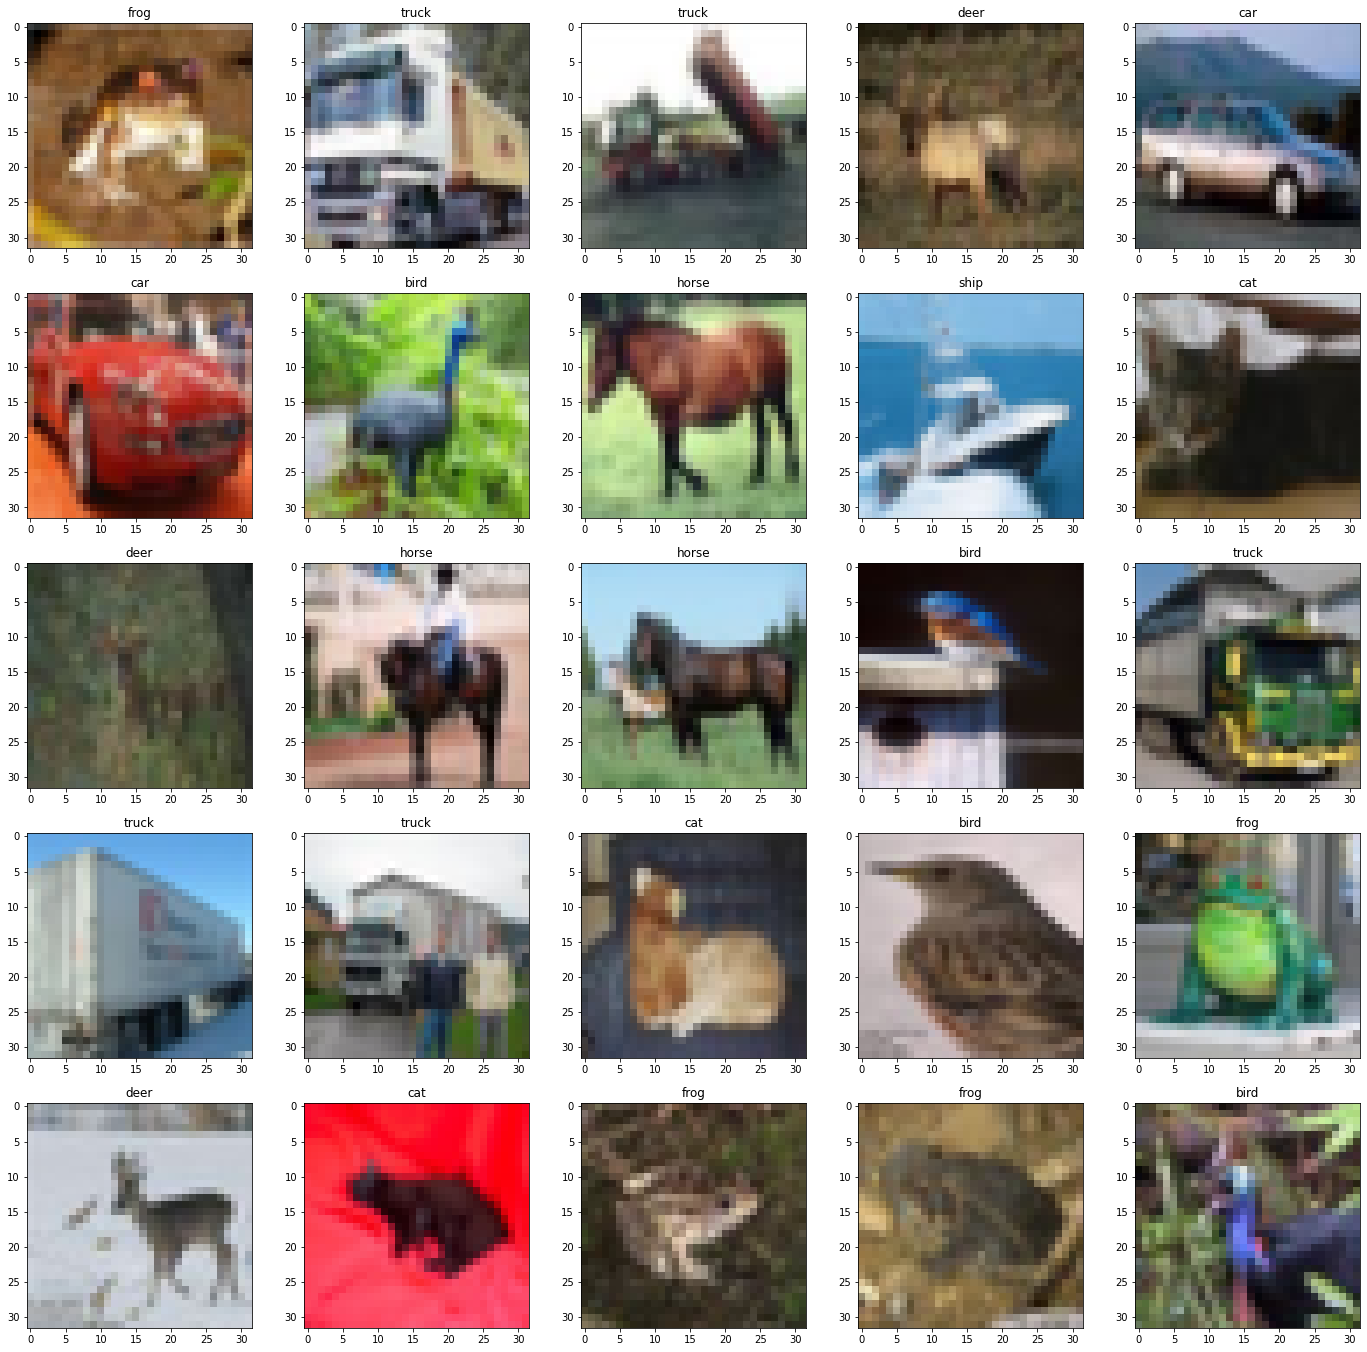

In [5]:
classes = ('plane', 'car', 'bird', 'cat','deer', 'dog', 'frog', 'horse', 'ship', 'truck')
fig, axarr  = plt.subplots(5, 5, figsize=(24, 24))
i = 0
for ax in axarr.flatten():
  img,label = train_set[i]
  ax.imshow(img)
  ax.set_title(classes[label], fontsize=12)
  i += 1
plt.show()

Q3. Create a (90-10) training and validation split using sklearn.model_selection.StratifiedShuffleSplit 

In [0]:
shuffler = StratifiedShuffleSplit(n_splits=1, test_size=0.1, random_state=42).split(train_set.data,train_set.targets)
indices = [(train_idx, validation_idx) for train_idx, validation_idx in shuffler][0]

Q4.Instantiate Datasets and Dataloader with correctly normalized CIFAR10, training, validation and test data

In [7]:
print(train_set.data.shape)
print(train_set.data.mean(axis=(0,1,2))/255)
print(train_set.data.std(axis=(0,1,2))/255)

(50000, 32, 32, 3)
[0.49139968 0.48215841 0.44653091]
[0.24703223 0.24348513 0.26158784]


Create a customerDateset, so that we could apply the transformation on the TensorDataset.

In [0]:
class CustomImageTensorDataset(Dataset):
    def __init__(self, data, targets, transform=None):
        """
        Args:
            data (Tensor): A tensor containing the data e.g. images
            targets (Tensor): A tensor containing all the labels
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.data = data
        self.targets = targets
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        sample, label = self.data[idx], self.targets[idx]
        
        if self.transform:
            sample = self.transform(sample)

        return sample, label

In [0]:
transform_nor = transforms.Compose([
    transforms.ToTensor(), ## normalize pixel values to the range 0 to 1
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2470, 0.2434, 0.2615)),
])

In [0]:
X_train, y_train = train_set.data[indices[0]], np.array(train_set.targets)[indices[0]]
X_val, y_val = train_set.data[indices[1]], np.array(train_set.targets)[indices[1]]
X_test, y_test =  test_set.data, np.array(test_set.targets)


In [0]:
cifar_train = CustomImageTensorDataset(X_train, torch.from_numpy(y_train).long(), transform=transform_nor)
cifar_validation = CustomImageTensorDataset(X_val, torch.from_numpy(y_val).long(), transform=transform_nor)
cifar_test = CustomImageTensorDataset(X_test, torch.from_numpy(y_test).long(), transform=transform_nor)

In [0]:
seed = 42
lr = 1e-2
momentum = 0.5
batch_size = 64
test_batch_size = 1000
n_epochs = 30

In [0]:
train_loader = DataLoader(cifar_train, batch_size=batch_size, shuffle=True, num_workers=2) 
validation_loader = DataLoader(cifar_validation, batch_size=test_batch_size, shuffle=False, num_workers=2)
test_loader = DataLoader(cifar_test, batch_size=test_batch_size, shuffle=False, num_workers=4)

Q5.modify LeNet5 from the morning excercise to be able to work with CIFAR10. 

In [0]:
class LeNet5(nn.Module):
  def __init__(self):
    super(LeNet5, self).__init__()
    self.c1 = nn.Conv2d(3, 6, kernel_size=5, stride=1)
    self.s2 = nn.MaxPool2d(kernel_size=2, stride=2)
    self.c3 = nn.Conv2d(6, 16, kernel_size=5, stride=1)
    self.s4 = nn.MaxPool2d(kernel_size=2, stride=2)
    self.c5 = nn.Linear(16*5*5, 120)
    self.f6 = nn.Linear(120, 84)
    self.output = nn.Linear(84, 10)
    self.act = nn.ReLU()
    
  def forward(self, x):
    x = self.act(self.c1(x))
    x = self.act(self.s2(x))
    x = self.act(self.c3(x))
    x = self.act(self.s4(x))
    x = x.view(-1, x.size(1)*x.size(2)*x.size(3))  ##returns a "flattened" view of the 2d tensor as inputs for the fully connected layer
    x = self.act(self.c5(x))
    x = self.act(self.f6(x))
    return self.output(x)

In [0]:
def train(model, optimizer, criterion, data_loader):
    model.train()
    train_loss, train_accuracy = 0, 0
    for X, y in data_loader:
        X, y = X.to(device), y.to(device)
        optimizer.zero_grad()
        a2 = model(X.view(-1, 3, 32, 32))
        loss = criterion(a2, y)
        loss.backward()
        train_loss += loss*X.size(0)
        y_pred = F.log_softmax(a2, dim=1).max(1)[1]
        train_accuracy += accuracy_score(y.cpu().numpy(), y_pred.detach().cpu().numpy())*X.size(0)
        optimizer.step()  
        
    return train_loss/len(data_loader.dataset), train_accuracy/len(data_loader.dataset)
  
def validate(model, criterion, data_loader):
    model.eval()
    validation_loss, validation_accuracy = 0., 0.
    for X, y in data_loader:
        with torch.no_grad():
            X, y = X.to(device), y.to(device)
            a2 = model(X.view(-1, 3, 32, 32))
            loss = criterion(a2, y)
            validation_loss += loss*X.size(0)
            y_pred = F.log_softmax(a2, dim=1).max(1)[1]
            validation_accuracy += accuracy_score(y.cpu().numpy(), y_pred.cpu().numpy())*X.size(0)
            
    return validation_loss/len(data_loader.dataset), validation_accuracy/len(data_loader.dataset)
  
def evaluate(model, data_loader):
    model.eval()
    ys, y_preds = [], []
    for X, y in data_loader:
        with torch.no_grad():
            X, y = X.to(device), y.to(device)
            a2 = model(X.view(-1, 3, 32, 32))
            y_pred = F.log_softmax(a2, dim=1).max(1)[1]
            ys.append(y.cpu().numpy())
            y_preds.append(y_pred.cpu().numpy())
            
    return np.concatenate(y_preds, 0),  np.concatenate(ys, 0)

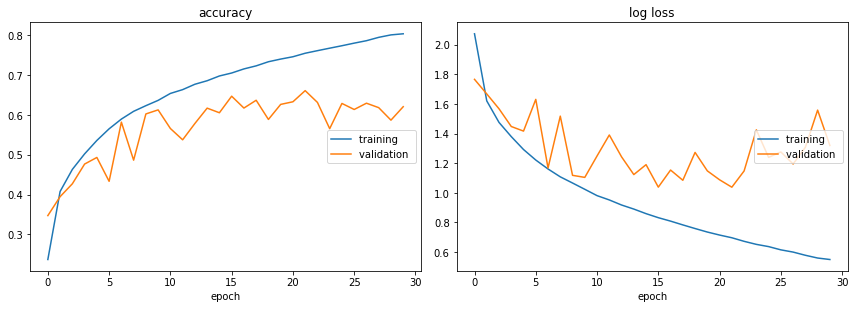

accuracy
	training         	 (min:    0.237, max:    0.804, cur:    0.804)
	validation       	 (min:    0.347, max:    0.661, cur:    0.621)
log loss
	training         	 (min:    0.550, max:    2.073, cur:    0.550)
	validation       	 (min:    1.038, max:    1.766, cur:    1.320)


In [16]:
def train_model(momentum):
  set_seed(seed)
  model = LeNet5().to(device)
  optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=momentum)
  criterion = nn.CrossEntropyLoss()
  
  liveloss = PlotLosses()
  for epoch in range(n_epochs):
      logs = {}
      train_loss, train_accuracy = train(model, optimizer, criterion, train_loader)

      logs['' + 'log loss'] = train_loss.item()
      logs['' + 'accuracy'] = train_accuracy.item()

      validation_loss, validation_accuracy = validate(model, criterion, validation_loader)
      logs['val_' + 'log loss'] = validation_loss.item()
      logs['val_' + 'accuracy'] = validation_accuracy.item()

      liveloss.update(logs)
      liveloss.draw()
      
  return model

model = train_model(0.5)

In [17]:
criterion = nn.CrossEntropyLoss()
test_loss, test_accuracy = validate(model, criterion, test_loader)    
print("Avg. Test Loss: %1.3f" % test_loss.item(), " Avg. Test Accuracy: %1.3f" % test_accuracy.item())

Avg. Test Loss: 1.365  Avg. Test Accuracy: 0.616


The accuracy on the train set is nearly 80%, while it is only 61.6% on the test set. As a consequence, we need to apply the regularization to deal with the over-fitting.

Q6.Perform a line-search over the L2-Regularization parameter, use the weight_decay=value keyword argument in the torch.optim modules 

In [0]:
def train_model(values):
  set_seed(seed)
  model = LeNet5().to(device)
  optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=momentum,weight_decay=values)
  criterion = nn.CrossEntropyLoss()
  
  # liveloss = PlotLosses()
  for epoch in range(n_epochs):
      # logs = {}
      train_loss, train_accuracy = train(model, optimizer, criterion, train_loader)

      # logs['' + 'log loss'] = train_loss.item()
      # logs['' + 'accuracy'] = train_accuracy.item()

      validation_loss, validation_accuracy = validate(model, criterion, validation_loader)
      # logs['val_' + 'log loss'] = validation_loss.item()
      # logs['val_' + 'accuracy'] = validation_accuracy.item()

      # liveloss.update(logs)
      # liveloss.draw()
  print("Avg. Train Loss: %1.3f" % train_loss.item(), " Avg. Trian Accuracy: %1.3f" % train_accuracy.item())
  print("Avg. Validate Loss: %1.3f" % validation_loss.item(), " Avg. Validate Accuracy: %1.3f" % validation_accuracy.item())
  test_loss, test_accuracy = validate(model, criterion, test_loader)    
  print("Avg. Test Loss: %1.3f" % test_loss.item(), " Avg. Test Accuracy: %1.3f" % test_accuracy.item())
      
  return model


In [19]:
model = train_model(0)

Avg. Train Loss: 0.550  Avg. Trian Accuracy: 0.804
Avg. Validate Loss: 1.320  Avg. Validate Accuracy: 0.621
Avg. Test Loss: 1.365  Avg. Test Accuracy: 0.616


In [20]:
model = train_model(1e-3)

Avg. Train Loss: 0.594  Avg. Trian Accuracy: 0.788
Avg. Validate Loss: 1.098  Avg. Validate Accuracy: 0.660
Avg. Test Loss: 1.122  Avg. Test Accuracy: 0.649


In [21]:
model = train_model(1e-4)

Avg. Train Loss: 0.550  Avg. Trian Accuracy: 0.802
Avg. Validate Loss: 1.244  Avg. Validate Accuracy: 0.633
Avg. Test Loss: 1.262  Avg. Test Accuracy: 0.630


In [22]:
model = train_model(1e-5)

Avg. Train Loss: 0.549  Avg. Trian Accuracy: 0.804
Avg. Validate Loss: 1.244  Avg. Validate Accuracy: 0.635
Avg. Test Loss: 1.273  Avg. Test Accuracy: 0.626


From the results, the best weight-decay value is ```1e-3```, since it is less over-fitting with a relatively high accuracy on the test set.

Q7. Choose the best weight-decay value given the other hyperparameters and train on the full CIFAR10 training set 

In [0]:
full_train_x, full_train_y = train_set.data, np.array(train_set.targets)
full_train = CustomImageTensorDataset(full_train_x, torch.from_numpy(full_train_y).long(), transform=transform_nor)
full_train_loader = DataLoader(full_train, batch_size=batch_size, shuffle=True, num_workers=4) 

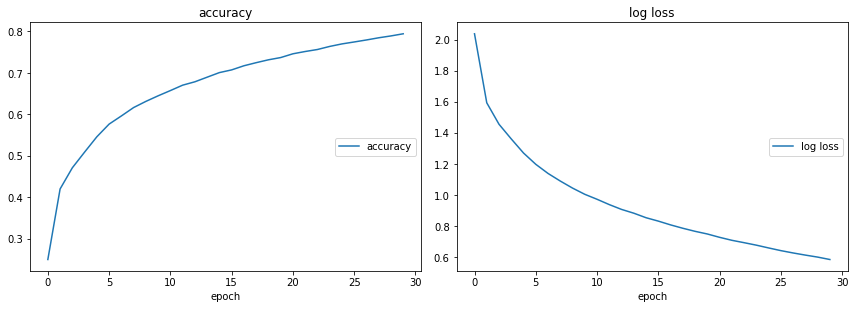

accuracy
	accuracy         	 (min:    0.250, max:    0.794, cur:    0.794)
log loss
	log loss         	 (min:    0.583, max:    2.038, cur:    0.583)


In [24]:
set_seed(seed)
model = LeNet5().to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=momentum,weight_decay=1e-3)
criterion = nn.CrossEntropyLoss()

liveloss = PlotLosses()
for epoch in range(n_epochs):
    logs = {}
    train_loss, train_accuracy = train(model, optimizer, criterion, full_train_loader)

    logs['' + 'log loss'] = train_loss.item()
    logs['' + 'accuracy'] = train_accuracy.item()

    liveloss.update(logs)
    liveloss.draw()

Q8. Test final model on the test set and store the model parameters in a .pth file 

In [25]:
test_loss, test_accuracy = validate(model, criterion, test_loader)    
print("Avg. Test Loss: %1.3f" % test_loss.item(), " Avg. Test Accuracy: %1.3f" % test_accuracy.item())

Avg. Test Loss: 1.093  Avg. Test Accuracy: 0.650


In [26]:
from sklearn.metrics import confusion_matrix

y_pred, y_gt = evaluate(model, test_loader)
C=confusion_matrix(y_gt, y_pred)
print(C)

[[652  28  75  13  56   3   6  10 122  35]
 [ 22 795  14   7   9   2   3   8  48  92]
 [ 56  11 597  41 139  43  40  32  22  19]
 [ 28  18 149 414 108 116  54  39  26  48]
 [ 18   6  93  43 713  22  28  49  15  13]
 [ 23   6 148 196  87 430  20  65   8  17]
 [ 18  13  89  63  86  21 670  10  11  19]
 [ 20   7  77  34 113  42   5 665   3  34]
 [ 43  49  26  11  19   2   3   1 813  33]
 [ 32 117  11  14  19   1   4   7  47 748]]


It can be seen from the confusion matrix that the final model is poorly classified on the picture with the label "cat".

In [27]:
!mkdir '/content/gdrive/My Drive/yw_models'  ## create the director for storing the model

model_save_name = 'LeNet5.pth' ## .pt and .pth are common file extensions for saving models in pytorch
path = F"/content/gdrive/My Drive/yw_models/{model_save_name}" 
torch.save(model.state_dict(), path)

mkdir: cannot create directory ‘/content/gdrive/My Drive/yw_models’: File exists


In [28]:
test_model = LeNet5().to(device) ## creates an instance of the model
test_model.load_state_dict(torch.load(path)) ## loads the parameters of the model in path. state_dict is a dictionary object that maps each layer in the model to its trainable parameters (weights and biases).
test_model.eval()

test_loss, test_accuracy = validate(test_model, criterion, test_loader)    
print("Avg. Test Loss: %1.3f" % test_loss.item(), " Avg. Test Accuracy: %1.3f" % test_accuracy.item())
print("")

Avg. Test Loss: 1.093  Avg. Test Accuracy: 0.650



Q9. Data-augmentation transforms

In [0]:
# https://discuss.pytorch.org/t/how-to-add-noise-to-mnist-dataset-when-using-pytorch/59745/2
class AddGaussianNoise(object):
    def __init__(self, mean=0., std=1.):
        self.std = std
        self.mean = mean
        
    def __call__(self, tensor):
        return tensor + torch.randn(tensor.size()) * self.std + self.mean
    
    def __repr__(self):
        return self.__class__.__name__ + '(mean={0}, std={1})'.format(self.mean, self.std)

In [0]:
Left_Right_Flips = transforms.RandomHorizontalFlip(p=1)
Rotate_10 = transforms.RandomRotation((0,10))
Rotate_90 = transforms.RandomRotation((0,90))
shift_image =  transforms.RandomCrop(32, padding=5)
Up_Down_Flips = transforms.RandomVerticalFlip(p=1)
Contrast_Changes = transforms.ColorJitter(contrast=1.5)

In [0]:
GaussianNoise=transforms.Compose([
    transforms.ToTensor(),
    AddGaussianNoise(0., 0.1),
    transforms.ToPILImage(),
])

Let's take an example from CIFAR10 to illustrate

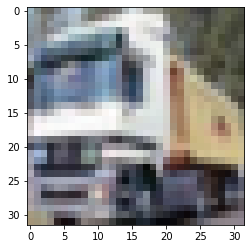

In [32]:
img,label = train_set[1]
plt.imshow(img)

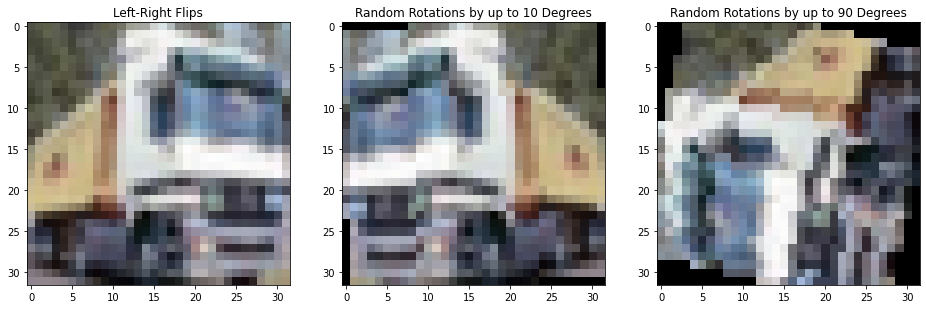

In [33]:

fig, axs  = plt.subplots(1,3, figsize=(16, 16))
axs[0].imshow(Left_Right_Flips(img))
axs[0].set_title("Left-Right Flips", fontsize=12)
axs[1].imshow(Rotate_10(img))
axs[1].set_title("Random Rotations by up to 10 Degrees", fontsize=12)
axs[2].imshow(Rotate_90(img))
axs[2].set_title("Random Rotations by up to 90 Degrees", fontsize=12)


plt.show()

Left-Right Flips:

For the transformed image, the value on each pixel is different from that of the origin image. And the transformed picture still presents the exact same characteristics of the origin image, Left-Right Flips is a good choice for data augmentation.

Random Rotations by up to 10 Degrees:

Although the transformed image loss a small amount of information, it stills maintains the main features from the origin image. So that, Random Rotations by up to 10 Degrees is a good choice for data augmentation.

Random Rotations by up to 90 Degrees:

For the dataset CIFAR10, the image size is only 32$\times$32. When the rotation angle is too large, there is a possibility of losing too much information and unable to distinguish the images.  Therefore, Random Rotations by up to 90 Degrees is not a suitable choice for such small image.

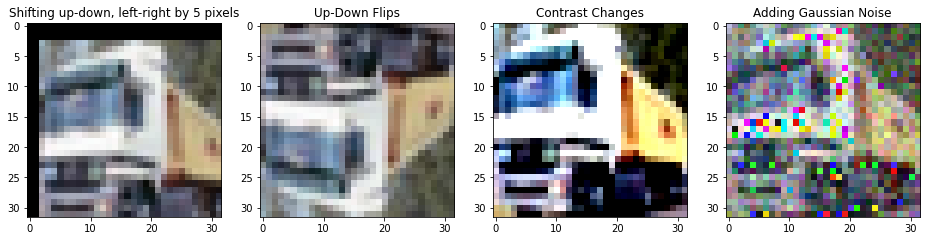

In [34]:
fig, axs  = plt.subplots(1,4, figsize=(16, 16))
axs[0].imshow(shift_image(img))
axs[0].set_title("Shifting up-down, left-right by 5 pixels", fontsize=12)
axs[1].imshow(Up_Down_Flips(img))
axs[1].set_title("Up-Down Flips", fontsize=12)
axs[2].imshow(Contrast_Changes(img))
axs[2].set_title("Contrast Changes", fontsize=12)
axs[3].imshow(GaussianNoise(img))
axs[3].set_title("Adding Gaussian Noise", fontsize=12)

plt.show()

Shifting up-down, left-right by 5 pixels:

Same as before. For the small image of size 32$\times$32, shifting image by 5 pixels poses the risk of losing too much information. Therefore, this is not a good choice for data augmentation.

Up-Down Flips:

Up-Down Flips is a good choice for data augmentation, since such transformation maintains main feature of the origin image and changes values on almost each pixel.

Contrast Changes:

Since the original image is very blurry, changing contrast will increase the difficulty of distinguishing the image. Therefore, this is not a suitable choice for CIFAR10

Adding Gaussian Noise:

Since the original image is very blurry, adding more noise will increase the difficulty of distinguishing the image. Therefore, this is not a suitable choice for CIFAR10.


Q10. Use data-augmentation to train a CIFAR10 classifier using the best value of weight-decay and the other given hyperparameters. 

In [0]:
transform_add = transforms.Compose([                            
    transforms.RandomHorizontalFlip(),
    # transforms.RandomRotation((0,10)),
    # transforms.RandomVerticalFlip(),
    transforms.ToTensor(), ## normalize pixel values to the range 0 to 1      
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2470, 0.2434, 0.2615))
])

In [36]:
cifar10_train_add = CIFAR10(root = "./", train=True, download = True, transform=transform_add)
train_loader_add = DataLoader(cifar10_train_add, batch_size=batch_size, shuffle=True,num_workers=4)

cifar10_test_add = CIFAR10(root = "./", train=False, download = True, transform=transform_nor)
test_loader_add = DataLoader(cifar10_test_add, batch_size=test_batch_size, shuffle=False,num_workers=4)

Files already downloaded and verified
Files already downloaded and verified


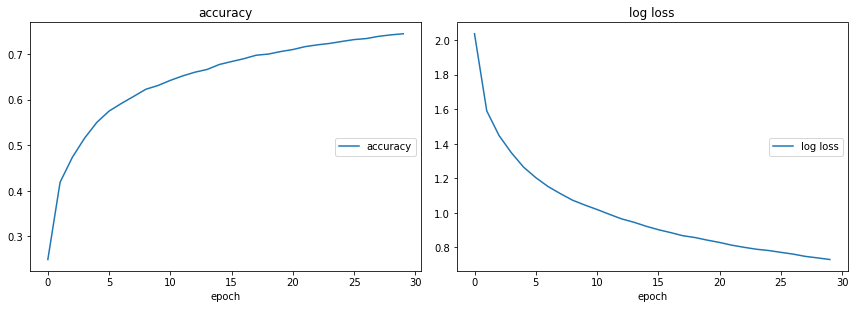

accuracy
	accuracy         	 (min:    0.249, max:    0.794, cur:    0.745)
log loss
	log loss         	 (min:    0.583, max:    2.038, cur:    0.730)


In [37]:
set_seed(seed)
model = LeNet5().to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=momentum, weight_decay=1e-3)
criterion = nn.CrossEntropyLoss()

liveloss = PlotLosses()
for epoch in range(n_epochs):
    logs = {}
    train_loss, train_accuracy = train(model, optimizer, criterion, train_loader_add)

    logs['' + 'log loss'] = train_loss.item()
    logs['' + 'accuracy'] = train_accuracy.item()

    liveloss.update(logs)
    liveloss.draw()

In [38]:
test_loss, test_accuracy = validate(model, criterion, test_loader_add)    
print("Avg. Test Loss: %1.3f" % test_loss.item(), " Avg. Test Accuracy: %1.3f" % test_accuracy.item())

Avg. Test Loss: 0.895  Avg. Test Accuracy: 0.696


After using data augmentation, the accuracy on the test set increases  from 65% to 69.6% and the accuracy on the train set is 74.5%. There is less over-fitting than the previous model. This demonstrates that such data augmentation is a good strategy to improve the model. On the other hand, data augmentation increases the running time per epoch, which means we cannot use it at will to solve the over-fitting. In this example, I only use the Left-Right-Flips to improve model. For example, I also try to add other methods(like: Up-Down-Flips and rotation) in the data augmentation. However, aftering adding more data augmentation, the average running time is more than 4 times that of the current model and the accracy for 30 epochs only reaches only 60% on the training and test sets.

Q11. Use the VGG  to beat LeNet5.

The main contribution of VGG is to use an architecture with a very small (3 × 3) convolution filter to increase the depth of the model. The reason for choosing VGG is that its architecture is very easy to implement and has the same high accuracy as GoogleNet.

In [0]:
# CNN constructure inspired from https://juejin.im/entry/5bf51d35e51d454049668d57
# delete several final layers from the origin structure of VGG
# since our dataset only contains 50000 images, there is no need to train a very deep model
class VGG(nn.Module):

    def __init__(self):
        super(VGG,self).__init__()
        self.conv1 = nn.Conv2d(3,64,3,padding=1)
        self.conv2 = nn.Conv2d(64,64,3,padding=1)
        self.pool1 = nn.MaxPool2d(2, 2)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu1 = nn.ReLU()

        self.conv3 = nn.Conv2d(64,128,3,padding=1)
        self.conv4 = nn.Conv2d(128, 128, 3,padding=1)
        self.pool2 = nn.MaxPool2d(2, 2, padding=1)
        self.bn2 = nn.BatchNorm2d(128)
        self.relu2 = nn.ReLU()

        self.conv5 = nn.Conv2d(128,128, 3,padding=1)
        self.conv6 = nn.Conv2d(128, 128, 3,padding=1)
        self.conv7 = nn.Conv2d(128, 128, 1,padding=1)
        self.pool3 = nn.MaxPool2d(2, 2, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.relu3 = nn.ReLU()

        # delete several final layers from the origin structure of VGG

        # self.conv8 = nn.Conv2d(128, 256, 3,padding=1)
        # self.conv9 = nn.Conv2d(256, 256, 3, padding=1)
        # self.conv10 = nn.Conv2d(256, 256, 1, padding=1)
        # self.pool4 = nn.MaxPool2d(2, 2, padding=1)
        # self.bn4 = nn.BatchNorm2d(256)
        # self.relu4 = nn.ReLU()

        # self.conv11 = nn.Conv2d(256, 512, 3, padding=1)
        # self.conv12 = nn.Conv2d(512, 512, 3, padding=1)
        # self.conv13 = nn.Conv2d(512, 512, 1, padding=1)
        # self.pool5 = nn.MaxPool2d(2, 2, padding=1)
        # self.bn5 = nn.BatchNorm2d(512)
        # self.relu5 = nn.ReLU()

        self.fc14 = nn.Linear(128*6*6,1024)
        self.drop1 = nn.Dropout2d()
        # self.fc15 = nn.Linear(1024,1024)
        # self.drop2 = nn.Dropout2d()
        self.fc16 = nn.Linear(1024,10)


    def forward(self,x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.pool1(x)
        x = self.bn1(x)
        x = self.relu1(x)


        x = self.conv3(x)
        x = self.conv4(x)
        x = self.pool2(x)
        x = self.bn2(x)
        x = self.relu2(x)

        x = self.conv5(x)
        x = self.conv6(x)
        x = self.conv7(x)
        x = self.pool3(x)
        x = self.bn3(x)
        x = self.relu3(x)

        # x = self.conv8(x)
        # x = self.conv9(x)
        # x = self.conv10(x)
        # x = self.pool4(x)
        # x = self.bn4(x)
        # x = self.relu4(x)

        # x = self.conv11(x)
        # x = self.conv12(x)
        # x = self.conv13(x)
        # x = self.pool5(x)
        # x = self.bn5(x)
        # x = self.relu5(x)
        # print(" x shape ",x.size())
        x = x.view(-1,128*6*6)
        # print(" x shape ",x.size())
        x = F.relu(self.fc14(x))
        x = self.drop1(x)
        # x = F.relu(self.fc15(x))
        # x = self.drop2(x)
        x = F.relu(self.fc16(x))

        return x

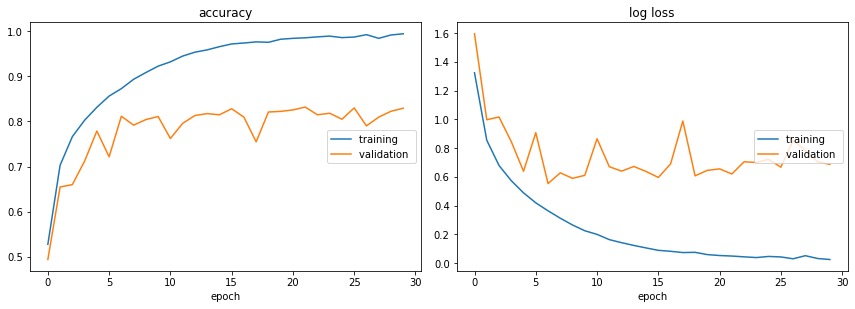

accuracy
	training         	 (min:    0.237, max:    0.995, cur:    0.995)
	validation       	 (min:    0.347, max:    0.832, cur:    0.829)
log loss
	training         	 (min:    0.024, max:    2.073, cur:    0.024)
	validation       	 (min:    0.553, max:    1.766, cur:    0.686)


In [40]:
set_seed(seed)
model = VGG().to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=momentum, weight_decay=1e-3)
criterion = nn.CrossEntropyLoss()
min_loss = 1
liveloss = PlotLosses()
for epoch in range(n_epochs):
    logs = {}
    train_loss, train_accuracy = train(model, optimizer, criterion, train_loader)

    logs['' + 'log loss'] = train_loss.item()
    logs['' + 'accuracy'] = train_accuracy.item()

    validation_loss, validation_accuracy = validate(model, criterion, validation_loader)
    logs['val_' + 'log loss'] = validation_loss.item()
    logs['val_' + 'accuracy'] = validation_accuracy.item()

    #Store best validation loss model
    if validation_loss < min_loss:
        torch.save(model.state_dict(), F"/content/gdrive/My Drive/yw_models/mnist_vae_"+str(epoch)+".pth")
        min_loss = validation_loss

    liveloss.update(logs)
    liveloss.draw()

In [41]:
test_loss, test_accuracy = validate(model, criterion, test_loader)    
print("Avg. Test Loss: %1.3f" % test_loss.item(), " Avg. Test Accuracy: %1.3f" % test_accuracy.item())

Avg. Test Loss: 0.730  Avg. Test Accuracy: 0.814


In [42]:
test_model = VGG().to(device) ## creates an instance of the model
path = "/content/gdrive/My Drive/yw_models/mnist_vae_6.pth"
test_model.load_state_dict(torch.load(path)) ## loads the parameters of the model in path. state_dict is a dictionary object that maps each layer in the model to its trainable parameters (weights and biases).
test_model.eval()

test_loss, test_accuracy = validate(test_model, criterion, test_loader)    
print("Avg. Test Loss: %1.3f" % test_loss.item(), " Avg. Test Accuracy: %1.3f" % test_accuracy.item())
print("")

Avg. Test Loss: 0.591  Avg. Test Accuracy: 0.802



In [45]:
from sklearn.metrics import confusion_matrix

y_pred, y_gt = evaluate(model, test_loader)
C=confusion_matrix(y_gt, y_pred)
print(C)

[[829  28  19  14   6   2   7   0  43  52]
 [  1 937   3   2   2   0   0   0   7  48]
 [ 47  11 753  44  32  31  44   8  14  16]
 [ 24  15  54 666  41  75  48  11  22  44]
 [ 12   4  45  49 802  15  29  23  12   9]
 [ 10  10  31 157  24 680  19  37   5  27]
 [  6  15  30  31  19   9 857   5  12  16]
 [ 14   9  22  27  42  31   6 805   4  40]
 [ 32  37   2   8   1   0   3   2 882  33]
 [ 10  51   3   3   0   0   1   0   7 925]]


From the result, VGG model improved the accuracy by 10%. As VGG is a quite complexe model with a large amount of parameters, I decided to not use data augmentation. Without data augmentation, our model overfits on 30 epochs. However, it only takes 6 epochs to reach 80% accuracy for a dataset without augmentation. This indicates we do not need to train 30 epochs for the VGG model on cifar10 dataset, while 6 epochs will be sufficient for training.